In [95]:
import numpy as np
import qiskit.pulse.library as pulse_lib
import qiskit.pulse as pulse
from qiskit.pulse.macros import measure_all
from qiskit.compiler import assemble
from qiskit.tools import job_monitor
from qiskit import IBMQ
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
import pickle

provider = IBMQ.load_account()
backend = provider.get_backend("ibmq_armonk")

def get_pi_pulse_01(c):
    return pulse_lib.gaussian(duration=c["drive_samples"], amp=c["pi_amp_01"], sigma=c["drive_sigma"], name="pi_pulse_01")

def get_pi_pulse_12(c):
    pulse = pulse_lib.gaussian(duration=c["drive_samples"], amp=c["pi_amp_12"], sigma=c["drive_sigma"], name="pi_pulse_12")
    t_samples = np.linspace(0, c["dt"]*c["drive_samples"], c["drive_samples"])
    sine_pulse = np.sin(2*np.pi*(c["qubit_12_freq"]-c["cal_qubit_freq"])*t_samples)
    return pulse_lib.SamplePulse(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')

def get_job_data(job, c):
    job_results = job.result(timeout=120)
    result_data = []
    for i in range(len(job_results.results)):
        result_data.append(job_results.get_memory(i)[:, 0]*c["scale_factor"])  
    return result_data

def assemble_sched(sched, backend, c):
    d = pulse.DriveChannel(0)
    size = len(sched)
    return assemble(sched, backend=backend, meas_level=1, meas_return="single", shots=1000, schedule_los=[{d: c["cal_qubit_freq"]}]*size)

def IQ_plot(data, color, label, filename):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(data), np.imag(data), s=5, cmap="viridis", c=color, alpha=0.5, label=label)
    mean = np.mean(data)
    plt.scatter(np.real(mean), np.imag(mean), s=200, cmap="viridis", c="black",alpha=1.0)
    
    plt.xlim(-10, 20)
    plt.ylim(-25, 10)
    plt.legend()
    plt.ylabel("I [a.u.]", fontsize=15)
    plt.xlabel("Q [a.u.]", fontsize=15)
    plt.title("", fontsize=15)
    plt.savefig(filename)
    plt.show()

def reshape_complex_vec(vec):
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

def train_discriminator(zero_data, one_data, two_data, shots):
    zero_data_reshaped = reshape_complex_vec(zero_data)
    one_data_reshaped = reshape_complex_vec(one_data)  
    two_data_reshaped = reshape_complex_vec(two_data) 
    IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
    state_012 = np.zeros(shots)
    state_012 = np.concatenate((state_012, np.ones(shots)))
    state_012 = np.concatenate((state_012, 2*np.ones(shots)))

    # Shuffle and split data into training and test sets
    IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

    lda = LinearDiscriminantAnalysis()
    lda.fit(IQ_012_train, state_012_train)
    score_012 = lda.score(IQ_012_test, state_012_test)
    print("Test score: ", 100*score_012)
    return lda

def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

def load_model(filename):
    with open(filename, 'rb') as file:
         return pickle.load(file)
        
def get_counts_from_data(data, model):
    data_reshaped = reshape_complex_vec(data)
    counts = {"0": 0, "1": 0, "2": 0}

    for i in data_reshaped:
        predict = model.predict(i.reshape(1, -1))
        if predict == 0:
            counts["0"] += 1
        if predict == 1:
            counts["1"] += 1
        if predict == 2:
            counts["2"] += 1
    return counts

calibration = {
    "backend_name": "ibmq_armonk",
    "calibration_date": "5-11-2020",
    "drive_samples": 2688,
    "drive_sigma": 336,
    "pi_amp_01": 0.22109871419576962,
    "pi_amp_12": 0.36665303953291,
    "cal_qubit_freq": 4974529080.135406,
    "scale_factor": 1e-14,
    "qubit_12_freq": 4626195988.353748,
    "dt": 2.2222222222222221e-10
}

pi_pulse_01 = get_pi_pulse_01(calibration)
pi_pulse_12 = get_pi_pulse_12(calibration)

drive_chan = pulse.DriveChannel(0)

zero = pulse.Schedule(name="zero")
zero |= measure_all(backend)

one = pulse.Schedule(name="one")
one |= pulse.Play(pi_pulse_01, drive_chan)
one |= measure_all(backend) << one.duration

two = pulse.Schedule(name="two")
two |= pulse.Play(pi_pulse_01, drive_chan)
two |= pulse.Play(pi_pulse_12, drive_chan) << two.duration
two |= measure_all(backend) << two.duration

prog = assemble_sched([zero, one, two], backend, calibration)
job = backend.run(prog)
job_monitor(job)

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-11-05 13:58:32,236: Credentials are already in use. The existing account in the session will be replaced.
/opt/conda/lib/python3.7/site-packages/qiskit/pulse/library/sample_pulse.py:42: DeprecationWarning: SamplePulse has been renamed to Waveform and is deprecated. Please replace SamplePulse(samples, channel) with Waveform(samples, channel).
  "Waveform(samples, channel).", DeprecationWarning)


Job Status: job has successfully run


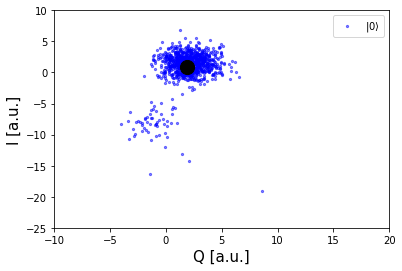

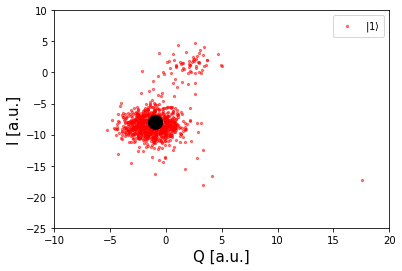

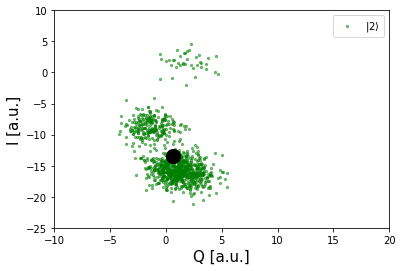

Test score:  84.8
{'0': 941, '1': 53, '2': 6}
{'0': 65, '1': 880, '2': 55}
{'0': 39, '1': 232, '2': 729}


In [96]:
data = get_job_data(job, calibration)

IQ_plot(data[0], "blue", r"$|0\rangle$", "zero_data.png")
IQ_plot(data[1], "red", r"$|1\rangle$", "one_data.png")
IQ_plot(data[2], "green", r"$|2\rangle$", "two_data.png")

lda = train_discriminator(data[0], data[1], data[2], 1000)
save_model(lda, "012-discriminator.pkl")
print(get_counts_from_data(data[0], lda))
print(get_counts_from_data(data[1], lda))
print(get_counts_from_data(data[2], lda))